In [1]:
# !ls adversarial-robustness-toolbox/
import os
os.chdir('/home/surthi/adversarial-robustness-toolbox/')


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import tensorflow as tf
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from keras.regularizers import l2
import numpy as np
from art.attacks import DeepFool
from art.classifiers import KerasClassifier
from art.utils import load_dataset

Using TensorFlow backend.


In [3]:
def evaluate(clf, x_train, y_train, x_test, y_test):
    # train acc
    train_preds = np.argmax(clf.predict(x_train), axis=1)
    train_acc = np.sum(train_preds == np.argmax(y_train, axis=1)) / y_train.shape[0]
    # test acc
    test_preds = np.argmax(clf.predict(x_test), axis=1)
    test_acc = np.sum(test_preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("\nTraining and Test accuracies: %.2f %.2f%%" % (train_acc*100, test_acc*100))
    return train_acc, test_acc

def plot_curves(model, title='model accuracy and loss'):
    import matplotlib.pyplot as plt
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['loss'])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss'], loc='upper left')
    return plt

def plot_acc_loss_curves(acc, loss, title, legend):
    import matplotlib.pyplot as plt
    plt.plot(acc)
    plt.plot(loss)
    plt.title(title)
    plt.xlabel('Epoch')
    return plt

def save_clf(c, folder, clf_filename, model_filename):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(clf_filename, "wb") as f:
        pickle.dump(c.__getstate__, f)
    c._model.save(model_filename)
    os.chdir(cwd)

DUMP_FOLDER = '/home/surthi/models/'
def pickle_dump(data, filename, folder=DUMP_FOLDER):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    os.chdir(cwd)

def pickle_load(filename):
    import pickle
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_clf(folder, clf_filename, model_filename):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(clf_filename, "rb") as f:
        clf_state = pickle.load(f)
    model = tf.keras.models.load_model(model_filename)
    os.chdir(cwd)
    clf = KerasClassifier(model=model)
    clf.__setstate__(clf_state())
    return clf, model

In [4]:
# import pickle
# x_train, y_train,\
# x_test, y_test,\
# x_train_fgsm_adv, x_test_fgsm_adv, \
# x_train_ifgsm_adv, x_test_ifgsm_adv,\
# x_train_deepfool_adv, x_test_deepfool_adv, \
# x_train_deepfool_adv_5to10, x_test_deepfool_adv_5to10, \
# x_train_cl2_adv, x_test_cl2_adv, \
# x_train_cl2_adv_5to10,x_test_cl2_adv_5to10, \
#  = pickle_load('/home/surthi/models/cifar10/vanilla_clf_adv_data.pkl')

In [5]:
# pickle_dump((x_train_fgsm_adv[0:3000], x_train_fgsm_adv[0:3000]), 'vanilla_clf_fgsm_data.pkl')
# pickle_dump((x_train_deepfool_adv[0:3000], x_test_deepfool_adv[0:3000]), 'vanilla_clf_deepfool_xtrain_xtest.pkl')
# pickle_dump((x_train_cl2_adv[0:3000], x_test_cl2_adv[0:3000]), 'vanilla_clf_cl2_xtrain_xtest.pkl')

In [6]:
(x_train, y_train, x_test, y_test) = pickle_load('/home/surthi/models/vanilla_clf_train_test_data.pkl')
(x_train_bim_adv, x_test_bim_adv) = pickle_load('/home/surthi/models/vanilla_clf_bim_xtrain_xtest.pkl')
(x_train_fgsm_adv, x_test_fgsm_adv) = pickle_load('/home/surthi/models/vanilla_clf_fgsm_data.pkl')
(x_train_deepfool_adv, x_test_deepfool_adv) = pickle_load('/home/surthi/models/vanilla_clf_deepfool_xtrain_xtest.pkl')
(x_train_cl2_adv, x_test_cl2_adv) = pickle_load('/home/surthi/models/vanilla_clf_cl2_xtrain_xtest.pkl')

In [61]:
resnet_train_acc, resnet_test_acc = evaluate(_m, x_train, y_train, x_test, y_test)
resnet_fgsm_train_acc, resnet_fgsm_test_acc = evaluate(_m, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
resnet_ifgsm_train_acc, resnet_ifgsm_test_acc = evaluate(_m, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
resnet_df_train_acc, resnet_df_test_acc = evaluate(_m, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
resnet_df_train_acc_2, resnet_df_test_acc_2 = evaluate(_m, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])
resnet_cl2_train_acc, resnet_cl2_test_acc = evaluate(_m, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])
resnet_cl2_train_acc_2, resnet_cl2_test_acc_2 = evaluate(_m, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 80.21 78.12%

Training and Test accuracies: 22.38 23.63%

Training and Test accuracies: 4.73 5.75%

Training and Test accuracies: 77.00 76.10%

Training and Test accuracies: 75.98 74.70%

Training and Test accuracies: 76.92 76.20%

Training and Test accuracies: 75.70 74.90%


In [62]:
_m_no_bn = tf.keras.models.load_model('adversarial-robustness-toolbox/saved_models/no_bn_cifar10_ResNet20v1_model.054.h5')

In [63]:
resnet_train_acc_no_bn, resnet_test_acc_no_bn = evaluate(_m_no_bn, x_train, y_train, x_test, y_test)
resnet_fgsm_train_acc_no_bn, resnet_fgsm_test_acc_no_bn = evaluate(_m_no_bn, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
resnet_ifgsm_train_acc_no_bn, resnet_ifgsm_test_acc_no_bn = evaluate(_m_no_bn, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
resnet_df_train_acc_no_bn, resnet_df_test_acc_no_bn = evaluate(_m_no_bn, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
resnet_df_train_acc_2_no_bn, resnet_df_test_acc_2_no_bn = evaluate(_m_no_bn, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])
resnet_cl2_train_acc_no_bn, resnet_cl2_test_acc_no_bn = evaluate(_m_no_bn, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])
resnet_cl2_train_acc_2_no_bn, resnet_cl2_test_acc_2_no_bn = evaluate(_m_no_bn, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 82.16 79.84%

Training and Test accuracies: 20.48 21.83%

Training and Test accuracies: 2.98 6.29%

Training and Test accuracies: 78.72 77.40%

Training and Test accuracies: 77.78 76.70%

Training and Test accuracies: 78.84 77.00%

Training and Test accuracies: 77.82 76.70%


In [64]:
c1, model1 = load_clf('/home/surthi/models/cifar10/', 'vanilla_clf.h5', 'vanilla_clf_model.h5')
c1_bn, model1_bn = load_clf('/home/surthi/models/cifar10/', 'vanilla_clf_with_bn.h5', 'vanilla_clf_with_bn_model.h5')

train_acc, test_acc = evaluate(c1, x_train, y_train, x_test, y_test)
fgsm_train_acc, fgsm_test_acc = evaluate(c1, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc, ifgsm_test_acc = evaluate(c1, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
df_train_acc, df_test_acc = evaluate(c1, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
df_train_acc_2, df_test_acc_2 = evaluate(c1, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])
cl2_train_acc, cl2_test_acc = evaluate(c1, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])
cl2_train_acc_2, cl2_test_acc_2 = evaluate(c1, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])

train_acc_bn, test_acc_bn = evaluate(c1_bn, x_train, y_train, x_test, y_test)
fgsm_train_acc_bn, fgsm_test_acc_bn = evaluate(c1_bn, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc_bn, ifgsm_test_acc_bn = evaluate(c1_bn, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
df_train_acc_bn, df_test_acc_bn = evaluate(c1_bn, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
df_train_acc_2_bn, df_test_acc_2_bn = evaluate(c1_bn, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])
cl2_train_acc_bn, cl2_test_acc_bn = evaluate(c1_bn, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])
cl2_train_acc_2_bn, cl2_test_acc_2_bn = evaluate(c1_bn, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 97.93 81.64%

Training and Test accuracies: 13.68 17.07%

Training and Test accuracies: 0.42 4.39%

Training and Test accuracies: 8.24 14.90%

Training and Test accuracies: 8.06 15.40%

Training and Test accuracies: 2.46 10.90%

Training and Test accuracies: 2.04 11.20%

Training and Test accuracies: 98.15 82.28%

Training and Test accuracies: 17.61 18.21%

Training and Test accuracies: 2.99 5.60%

Training and Test accuracies: 96.66 82.70%

Training and Test accuracies: 96.82 81.00%

Training and Test accuracies: 96.36 82.70%

Training and Test accuracies: 96.86 80.30%


In [65]:
acc1 = (train_acc, df_train_acc, cl2_train_acc, fgsm_train_acc, ifgsm_train_acc)
test_acc1 = (test_acc, df_test_acc, cl2_test_acc, fgsm_test_acc, ifgsm_test_acc)
acc_bn1 = (train_acc_bn, df_train_acc_bn, cl2_train_acc_bn, fgsm_train_acc_bn, ifgsm_train_acc_bn)
test_acc_bn1 = (test_acc_bn, df_test_acc_bn, cl2_test_acc_bn, fgsm_test_acc_bn, ifgsm_test_acc_bn)

# resnet_train_acc_no_bn, resnet_test_acc_no_bn
resnet_acc1 = (resnet_train_acc_no_bn, resnet_df_train_acc_no_bn, resnet_cl2_train_acc_no_bn, resnet_fgsm_train_acc_no_bn, resnet_ifgsm_train_acc_no_bn)
resnet_test_acc1 = (resnet_test_acc_no_bn, resnet_df_test_acc_no_bn, resnet_cl2_test_acc_no_bn, resnet_fgsm_test_acc_no_bn, resnet_ifgsm_test_acc_no_bn)
resnet_acc_bn1 = (resnet_train_acc, resnet_df_train_acc, resnet_cl2_train_acc, resnet_fgsm_train_acc, resnet_ifgsm_train_acc)
resnet_test_acc_bn1 = (resnet_test_acc, resnet_df_test_acc, resnet_cl2_test_acc, resnet_fgsm_test_acc, resnet_ifgsm_test_acc)

In [69]:
# pickle_dump((acc1, test_acc1,
#              acc_bn1, test_acc_bn1, 
#              resnet_acc1, resnet_test_acc1, 
#              resnet_acc_bn1, resnet_test_acc_bn1), "accuracies.pkl")
(acc1, test_acc1,
             acc_bn1, test_acc_bn1, 
             resnet_acc1, resnet_test_acc1, 
             resnet_acc_bn1, resnet_test_acc_bn1)

((0.97934, 0.0824, 0.0246, 0.13678, 0.00416),
 (0.8164, 0.149, 0.109, 0.1707, 0.0439),
 (0.98146, 0.9666, 0.9636, 0.17614, 0.0299),
 (0.8228, 0.827, 0.827, 0.1821, 0.056),
 (0.8216, 0.7872, 0.7884, 0.20482, 0.02984),
 (0.7984, 0.774, 0.77, 0.2183, 0.0629),
 (0.8021, 0.77, 0.7692, 0.22378, 0.0473),
 (0.7812, 0.761, 0.762, 0.2363, 0.0575))

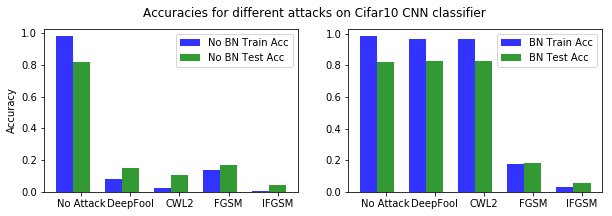

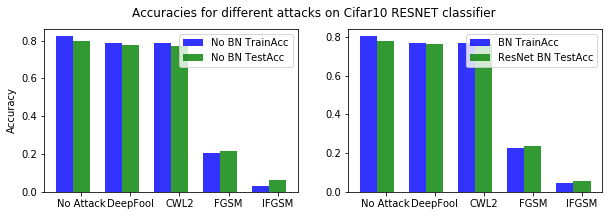

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 5
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.suptitle('Accuracies for different attacks on Cifar10 CNN classifier')
rects1 = plt.bar(index, acc1, bar_width,
alpha=opacity, color='b', label='No BN Train Acc')
rects2 = plt.bar(index + bar_width, test_acc1, bar_width,
alpha=opacity, color='g', label='No BN Test Acc')
# plt.xlabel('Attack Types')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, ('No Attack', 'DeepFool', 'CWL2', 'FGSM', 'IFGSM'))
plt.legend()

plt.subplot(1, 2, 2)
rects3 = plt.bar(index, acc_bn1, bar_width,
alpha=opacity,
color='b',
label='BN Train Acc')
rects4 = plt.bar(index + bar_width, test_acc_bn1, bar_width,
                 alpha=opacity, color='g', label='BN Test Acc')
plt.xticks(index + bar_width, ('No Attack', 'DeepFool', 'CWL2', 'FGSM', 'IFGSM'))
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.suptitle('Accuracies for different attacks on Cifar10 RESNET classifier')
plt.subplot(1, 2, 1)
rects5 = plt.bar(index, resnet_acc1, bar_width,
alpha=opacity,
color='b',
label='No BN TrainAcc')
rects6 = plt.bar(index + bar_width, resnet_test_acc1, bar_width,
                 alpha=opacity, color='g', label='No BN TestAcc')
# plt.xlabel('Attack Types')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, ('No Attack', 'DeepFool', 'CWL2', 'FGSM', 'IFGSM'))
plt.legend()

plt.subplot(1, 2, 2)
rects7 = plt.bar(index, resnet_acc_bn1, bar_width, alpha=opacity, color='b', label='BN TrainAcc')
rects8 = plt.bar(index + bar_width, resnet_test_acc_bn1, bar_width, alpha=opacity, color='g', label='ResNet BN TestAcc')
plt.xticks(index + bar_width, ('No Attack', 'DeepFool', 'CWL2', 'FGSM', 'IFGSM'))
plt.legend()


# plt.tight_layout()
plt.show()
fig.savefig('cifar10-acc-histograms.png')

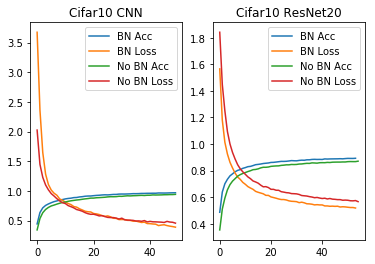

In [28]:
def plot_ax_acc_loss_curves(ax, acc, loss, title):
    ax.plot(acc)
    ax.plot(loss)

# ResNet cifar10
loss     = [1.5657, 1.1802, 1.0139, 0.9252, 0.8628, 0.8200, 0.7815, 0.7518, 0.7344, 0.7118, 0.6971, 0.6799, 0.6691, 0.6595, 0.6441, 0.6372, 0.6315, 0.6257, 0.6142, 0.6138, 0.6023, 0.5976, 0.5926, 0.5868, 0.5827, 0.5827, 0.5793, 0.5729, 0.5695, 0.5685, 0.5667, 0.5592, 0.5627, 0.5580, 0.5508, 0.5500, 0.5475, 0.5424, 0.5441, 0.5421, 0.5421, 0.5346, 0.5346, 0.5320, 0.5329, 0.5314, 0.5324, 0.5266, 0.5284, 0.5272, 0.5247, 0.5226, 0.5226, 0.5188]
accuracy = [0.4867, 0.6389, 0.7013, 0.7349, 0.7609, 0.7761, 0.7914, 0.8023, 0.8079, 0.8175, 0.8230, 0.8300, 0.8322, 0.8382, 0.8449, 0.8471, 0.8500, 0.8538, 0.8558, 0.8578, 0.8618, 0.8625, 0.8648, 0.8673, 0.8698, 0.8696, 0.8705, 0.8728, 0.8757, 0.8745, 0.8740, 0.8770, 0.8789, 0.8782, 0.8816, 0.8817, 0.8844, 0.8852, 0.8843, 0.8847, 0.8841, 0.8884, 0.8873, 0.8882, 0.8885, 0.8889, 0.8891, 0.8899, 0.8890, 0.8909, 0.8923, 0.8920, 0.8919, 0.8932]
loss_no_bn     = [1.8415, 1.4488, 1.2508, 1.0944, 1.0006, 0.9367, 0.8873, 0.8445, 0.8141, 0.7914, 0.7723, 0.7529, 0.7394, 0.7224, 0.7149, 0.7059, 0.6908, 0.6785, 0.6797, 0.6728, 0.6596, 0.6594, 0.6527, 0.6523, 0.6417, 0.6384, 0.6344, 0.6327, 0.6274, 0.6266, 0.6253, 0.6209, 0.6129, 0.6109, 0.6090, 0.6046, 0.6015, 0.5965, 0.5985, 0.5939, 0.5904, 0.5927, 0.5870, 0.5906, 0.5856, 0.5843, 0.5820, 0.5821, 0.5774, 0.5785, 0.5773, 0.5735, 0.5728, 0.5750, 0.5668]
accuracy_no_bn = [0.3541, 0.5108, 0.5930, 0.6556, 0.6950, 0.7214, 0.7399, 0.7586, 0.7700, 0.7789, 0.7859, 0.7933, 0.7995, 0.8073, 0.8091, 0.8135, 0.8210, 0.8255, 0.8254, 0.8274, 0.8324, 0.8341, 0.8355, 0.8361, 0.8397, 0.8413, 0.8438, 0.8438, 0.8466, 0.8460, 0.8468, 0.8498, 0.8504, 0.8530, 0.8551, 0.8545, 0.8586, 0.8577, 0.8565, 0.8597, 0.8602, 0.8599, 0.8622, 0.8613, 0.8637, 0.8642, 0.8645, 0.8645, 0.8654, 0.8653, 0.8678, 0.8685, 0.8681, 0.8681, 0.8713]

# CNN cifar10
vanilla_clf_with_bn_loss = [3.6753, 2.3651, 1.6466, 1.2835, 1.1075, 1.0145, 0.9608, 0.9270, 0.8644, 0.8407, 0.8118, 0.7878, 0.7686, 0.7359, 0.7263, 0.6982, 0.6785, 0.6570, 0.6483, 0.6447, 0.6188, 0.6124, 0.6016, 0.5827, 0.5705, 0.5784, 0.5625, 0.5383, 0.5362, 0.5162, 0.5170, 0.5172, 0.5034, 0.5021, 0.4891, 0.4908, 0.4785, 0.4674, 0.4732, 0.4491, 0.4474, 0.4420, 0.4387, 0.4152, 0.4239, 0.4288, 0.4154, 0.4055, 0.3983, 0.3885]
vanilla_clf_with_bn_acc  = [0.4431, 0.6351, 0.7142, 0.7549, 0.7800, 0.8007, 0.8188, 0.8310, 0.8447, 0.8538, 0.8651, 0.8726, 0.8774, 0.8869, 0.8891, 0.8980, 0.9026, 0.9100, 0.9135, 0.9141, 0.9194, 0.9239, 0.9266, 0.9313, 0.9341, 0.9324, 0.9359, 0.9404, 0.9407, 0.9461, 0.9471, 0.9468, 0.9484, 0.9502, 0.9536, 0.9531, 0.9545, 0.9574, 0.9574, 0.9593, 0.9597, 0.9608, 0.9606, 0.9649, 0.9644, 0.9637, 0.9648, 0.9667, 0.9679, 0.9686]
vanilla_clf_loss         = [2.0254, 1.4478, 1.2282, 1.1005, 1.0181, 0.9543, 0.9134, 0.8685, 0.8306, 0.8003, 0.7865, 0.7518, 0.7338, 0.7134, 0.6857, 0.6733, 0.6570, 0.6332, 0.6156, 0.6049, 0.6068, 0.5939, 0.5780, 0.5830, 0.5669, 0.5533, 0.5502, 0.5500, 0.5415, 0.5253, 0.5402, 0.5121, 0.5081, 0.5056, 0.5030, 0.4914, 0.4939, 0.4872, 0.4996, 0.4767, 0.4862, 0.4788, 0.4779, 0.4751, 0.4729, 0.4675, 0.4861, 0.4748, 0.4709, 0.4561]
vanilla_clf_accuracy     = [0.3420, 0.5344, 0.6320, 0.6868, 0.7213, 0.7461, 0.7608, 0.7772, 0.7917, 0.8052, 0.8123, 0.8246, 0.8328, 0.8398, 0.8465, 0.8513, 0.8587, 0.8654, 0.8707, 0.8783, 0.8784, 0.8843, 0.8866, 0.8897, 0.8929, 0.8986, 0.9021, 0.9016, 0.9033, 0.9095, 0.9081, 0.9132, 0.9173, 0.9154, 0.9186, 0.9202, 0.9230, 0.9251, 0.9225, 0.9269, 0.9271, 0.9320, 0.9305, 0.9315, 0.9326, 0.9352, 0.9357, 0.9378, 0.9380, 0.9415]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.suptitle('Cifar10 Accuracy and Loss')

plot_ax_acc_loss_curves(ax1, vanilla_clf_with_bn_acc, vanilla_clf_with_bn_loss, "Cifar10 CNN Accuracy and Loss")
plot_ax_acc_loss_curves(ax1, vanilla_clf_accuracy, vanilla_clf_loss, "Cifar10 CNN Accuracy and Loss")
ax1.legend(['BN Acc', 'BN Loss', 'No BN Acc', 'No BN Loss'], loc='upper right')
ax1.set_title("Cifar10 CNN")

plot_ax_acc_loss_curves(ax2, accuracy, loss, "Cifar10 ResNet20 Accuracy and Loss")
plot_ax_acc_loss_curves(ax2, accuracy_no_bn, loss_no_bn, "Cifar10 ResNet20 Accuracy and Loss")
ax2.legend(['BN Acc', 'BN Loss', 'No BN Acc', 'No BN Loss'], loc='upper right')
ax2.set_title("Cifar10 ResNet20")
fig.savefig('cifar10-acc-curves.png')

In [19]:
cnn_clf_adv_final, cnn_model_adv_final = load_clf('/home/surthi/models/cifar10/', 'cnn_clf_adv1_trained_final.h5', 'cnn_bn_model_adv1_trained_final.h5')
resnet_clf_adv_final, resnet_model_adv_final = load_clf('/home/surthi/models/cifar10/', 'resnet_clf_adv1_trained_180_epochs.h5', 'resnet_model_adv1_trained_180_epochs.h5')

In [6]:
cnn_bn_clf_adv_final, cnn_bn_model_adv_final = load_clf('/home/surthi/models/cifar10/', 'cnn_bn_clf_adv1_trained_final_again.h5', 'cnn_bn_model_adv1_trained_final_again.h5')
resnet_bn_clf_adv_final, cnn_bn_model_adv_final = load_clf('/home/surthi/models/cifar10/', 'resnet_clf_adv1_trained_8_epochs.h5', 'resnet_model_adv1_trained_8_epochs.h5')
# save_clf(resnet_clf_bn, '/home/surthi/models/cifar10/', 'resnet_clf_adv1_trained_8_epochs.h5', 'resnet_model_adv1_trained_8_epochs.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [7]:
bn_train_acc, bn_test_acc = evaluate(cnn_bn_clf_adv_final, x_train, y_train, x_test, y_test)
bn_fgsm_train_acc, bn_fgsm_test_acc = evaluate(cnn_bn_clf_adv_final, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
bn_ifgsm_train_acc, bn_ifgsm_test_acc = evaluate(cnn_bn_clf_adv_final, x_train_bim_adv, y_train, x_test_bim_adv, y_test)
bn_df_train_acc, bn_df_test_acc = evaluate(cnn_bn_clf_adv_final, x_train_deepfool_adv, y_train[:3000], x_test_deepfool_adv, y_test[:1000])
bn_cl2_train_acc, bn_cl2_test_acc = evaluate(cnn_bn_clf_adv_final, x_train_cl2_adv, y_train[:3000], x_test_cl2_adv, y_test[:1000])

bn_rn_train_acc, bn_rn_test_acc = evaluate(resnet_bn_clf_adv_final, x_train, y_train, x_test, y_test)
bn_rn_fgsm_train_acc, bn_rn_fgsm_test_acc = evaluate(resnet_bn_clf_adv_final, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
bn_rn_ifgsm_train_acc, bn_rn_ifgsm_test_acc = evaluate(resnet_bn_clf_adv_final, x_train_bim_adv, y_train, x_test_bim_adv, y_test)
bn_rn_df_train_acc, bn_rn_df_test_acc = evaluate(resnet_bn_clf_adv_final, x_train_deepfool_adv, y_train[:3000], x_test_deepfool_adv, y_test[:1000])
bn_rn_cl2_train_acc, bn_rn_cl2_test_acc = evaluate(resnet_bn_clf_adv_final, x_train_cl2_adv, y_train[:3000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 97.01 79.00%


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys



Training and Test accuracies: 0.00 0.00%

Training and Test accuracies: 13.02 13.62%

Training and Test accuracies: 95.50 78.60%

Training and Test accuracies: 95.43 78.60%

Training and Test accuracies: 95.84 77.78%

Training and Test accuracies: 0.00 0.00%

Training and Test accuracies: 17.89 17.17%

Training and Test accuracies: 94.67 77.60%

Training and Test accuracies: 94.77 77.50%


In [8]:
bn_adv_acc1 = (bn_train_acc, bn_df_train_acc, bn_cl2_train_acc, bn_fgsm_train_acc, bn_ifgsm_train_acc)
bn_adv_test_acc1 = (bn_test_acc, bn_df_test_acc, bn_cl2_test_acc, bn_fgsm_test_acc, bn_ifgsm_test_acc)
bn_adv_acc_rn1 = (bn_rn_train_acc, bn_rn_df_train_acc, bn_rn_cl2_train_acc, bn_rn_fgsm_train_acc, bn_rn_ifgsm_train_acc)
bn_adv_test_acc_rn1 = (bn_rn_test_acc, bn_rn_df_test_acc, bn_rn_cl2_test_acc, bn_rn_fgsm_test_acc, bn_rn_ifgsm_test_acc)

print(bn_adv_acc1, bn_adv_test_acc1, bn_adv_acc_rn1, bn_adv_test_acc_rn1)

(0.97014, 0.955, 0.9543333333333334, 0.0, 0.13022) (0.79, 0.786, 0.786, 0.0, 0.1362) (0.9584, 0.9466666666666667, 0.9476666666666667, 0.0, 0.17888) (0.7778, 0.776, 0.775, 0.0, 0.1717)


In [9]:
train_acc, test_acc = evaluate(cnn_clf_adv_final, x_train, y_train, x_test, y_test)
fgsm_train_acc, fgsm_test_acc = evaluate(cnn_clf_adv_final, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc, ifgsm_test_acc = evaluate(cnn_clf_adv_final, x_train_bim_adv, y_train, x_test_bim_adv, y_test)
df_train_acc, df_test_acc = evaluate(cnn_clf_adv_final, x_train_deepfool_adv, y_train[:3000], x_test_deepfool_adv, y_test[:1000])
cl2_train_acc, cl2_test_acc = evaluate(cnn_clf_adv_final, x_train_cl2_adv, y_train[:3000], x_test_cl2_adv, y_test[:1000])

rn_train_acc, rn_test_acc = evaluate(resnet_clf_adv_final, x_train, y_train, x_test, y_test)
rn_fgsm_train_acc, rn_fgsm_test_acc = evaluate(resnet_clf_adv_final, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
rn_ifgsm_train_acc, rn_ifgsm_test_acc = evaluate(resnet_clf_adv_final, x_train_bim_adv, y_train, x_test_bim_adv, y_test)
rn_df_train_acc, rn_df_test_acc = evaluate(resnet_clf_adv_final, x_train_deepfool_adv, y_train[:3000], x_test_deepfool_adv, y_test[:1000])
rn_cl2_train_acc, rn_cl2_test_acc = evaluate(resnet_clf_adv_final, x_train_cl2_adv, y_train[:3000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 98.54 78.86%


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys



Training and Test accuracies: 0.00 0.00%

Training and Test accuracies: 78.58 46.73%

Training and Test accuracies: 95.90 76.80%

Training and Test accuracies: 95.80 77.00%

Training and Test accuracies: 97.27 77.17%

Training and Test accuracies: 0.00 0.00%

Training and Test accuracies: 71.33 51.09%

Training and Test accuracies: 95.93 76.70%

Training and Test accuracies: 95.90 76.40%


In [10]:
adv_acc1 = (train_acc, df_train_acc, cl2_train_acc, fgsm_train_acc, ifgsm_train_acc)
adv_test_acc1 = (test_acc, df_test_acc, cl2_test_acc, fgsm_test_acc, ifgsm_test_acc)
adv_acc_rn1 = (rn_train_acc, rn_df_train_acc, rn_cl2_train_acc, rn_fgsm_train_acc, rn_ifgsm_train_acc)
adv_test_acc_rn1 = (rn_test_acc, rn_df_test_acc, rn_cl2_test_acc, rn_fgsm_test_acc, rn_ifgsm_test_acc)

print(adv_acc1, adv_test_acc1, adv_acc_rn1, adv_test_acc_rn1)

(0.98538, 0.959, 0.958, 0.0, 0.78576) (0.7886, 0.768, 0.77, 0.0, 0.4673) (0.97272, 0.9593333333333334, 0.959, 0.0, 0.71328) (0.7717, 0.767, 0.764, 0.0, 0.5109)


In [9]:
(acc1, test_acc1,
 acc_bn1, test_acc_bn1, 
 resnet_acc1, resnet_test_acc1, 
 resnet_acc_bn1, resnet_test_acc_bn1, 
 adv_acc1, adv_test_acc1, 
 adv_acc_rn1, adv_test_acc_rn1,
 bn_adv_acc1, bn_adv_test_acc1, 
 bn_adv_acc_rn1, bn_adv_test_acc_rn1) = ((0.97934, 0.0824, 0.0246, 0.13678, 0.00416),
 (0.8164, 0.149, 0.109, 0.1707, 0.0439),
 (0.98146, 0.9666, 0.9636, 0.17614, 0.0299),
 (0.8228, 0.827, 0.827, 0.1821, 0.056),
 (0.8216, 0.7872, 0.7884, 0.20482, 0.02984),
 (0.7984, 0.774, 0.77, 0.2183, 0.0629),
 (0.8021, 0.77, 0.7692, 0.22378, 0.0473),
 (0.7812, 0.761, 0.762, 0.2363, 0.0575),
 (0.98538, 0.959, 0.958, 0.0, 0.78576), 
 (0.7886, 0.768, 0.77, 0.0, 0.4673),
 (0.97272, 0.9593333333333334, 0.959, 0.0, 0.71328),
 (0.7717, 0.767, 0.764, 0.0, 0.5109),
 (0.97014, 0.955, 0.9543333333333334, 0.0, 0.13022),
 (0.79, 0.786, 0.786, 0.0, 0.1362),
 (0.9584, 0.9466666666666667, 0.9476666666666667, 0.0, 0.17888),
 (0.7778, 0.776, 0.775, 0.0, 0.1717))

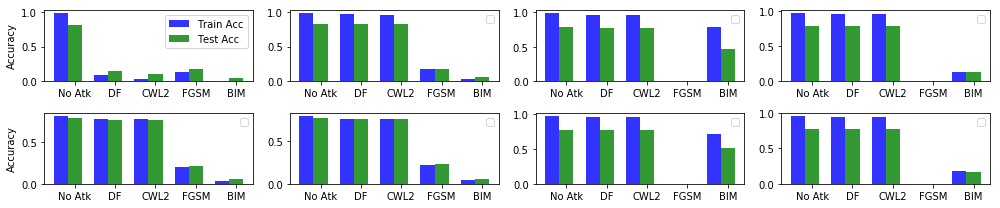

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

plt.figure(figsize=(14,3))
plt.subplot(2, 4, 1)
# plt.suptitle('Accuracies for different attacks on Cifar10 No BN CNN, BN CNN and Adversarially Trained CNN classifier')
rects1 = plt.bar(index, acc1, bar_width, alpha=opacity, color='b', label='Train Acc')
rects2 = plt.bar(index + bar_width, test_acc1, bar_width, alpha=opacity, color='g', label='Test Acc')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 2)
rects3 = plt.bar(index, acc_bn1, bar_width, alpha=opacity, color='b')#, label='BN Train Acc')
rects4 = plt.bar(index + bar_width, test_acc_bn1, bar_width, alpha=opacity, color='g')# label='BN Test Acc')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 3)
rects5 = plt.bar(index, adv_acc1, bar_width, alpha=opacity, color='b')# label='AdvClf Train Acc')
rects6 = plt.bar(index + bar_width, adv_test_acc1, bar_width, alpha=opacity, color='g')#, label='AdvClf Test Acc')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 4)
rects5 = plt.bar(index, bn_adv_acc1, bar_width, alpha=opacity, color='b')#, label='AdvClf Train Acc')
rects6 = plt.bar(index + bar_width, bn_adv_test_acc1, bar_width, alpha=opacity, color='g')#, label='AdvClf Test Acc')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 5)
# plt.suptitle('Accuracies for different attacks on Cifar10 No BN CNN, BN CNN and Adversarially Trained CNN classifier')
rects1 = plt.bar(index, resnet_acc1, bar_width, alpha=opacity, color='b')#, label='No BN Train Acc')
rects2 = plt.bar(index + bar_width, resnet_test_acc1, bar_width, alpha=opacity, color='g')#, label='No BN Test Acc')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 6)
rects3 = plt.bar(index, resnet_acc_bn1, bar_width, alpha=opacity, color='b')#, label='BN Train Acc')
rects4 = plt.bar(index + bar_width, resnet_test_acc_bn1, bar_width, alpha=opacity, color='g')#, label='BN Test Acc')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 7)
rects5 = plt.bar(index, adv_acc_rn1, bar_width, alpha=opacity, color='b')#, label='AdvClf Train Acc')
rects6 = plt.bar(index + bar_width, adv_test_acc_rn1, bar_width, alpha=opacity, color='g')#, label='AdvClf Test Acc')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.subplot(2, 4, 8)
rects5 = plt.bar(index, bn_adv_acc_rn1, bar_width, alpha=opacity, color='b')#, label='AdvClf Train Acc')
rects6 = plt.bar(index + bar_width, bn_adv_test_acc_rn1, bar_width, alpha=opacity, color='g')#, label='AdvClf Test Acc')
plt.xticks(index + bar_width, ('No Atk', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

plt.tight_layout()
plt.show()



In [18]:
import numpy.linalg as la
def loss_sensitivity(classifier, x, y):
    grads = classifier.loss_gradient(x, y)
    norm = la.norm(grads.reshape(grads.shape[0], -1), ord=2, axis=1)
    return np.mean(norm)

In [22]:
adv_ls_clean_bn = loss_sensitivity(cnn_clf_adv_final, x_train[:3000], y_train[:3000])
adv_ls_clean = loss_sensitivity(cnn_clf_adv_final, x_train[:3000], y_train[:3000])

adv_ls_df_bn = loss_sensitivity(cnn_bn_clf_adv_final, x_train_deepfool_adv, y_train[:3000])
adv_ls_cl2_bn = loss_sensitivity(cnn_bn_clf_adv_final, x_train_cl2_adv, y_train[:3000])
adv_ls_fgsm_bn = loss_sensitivity(cnn_bn_clf_adv_final, x_train_fgsm_adv[:3000], y_train[:3000])
adv_ls_ifgsm_bn = loss_sensitivity(cnn_bn_clf_adv_final, x_train_bim_adv[:3000], y_train[:3000])

adv_ls_df = loss_sensitivity(cnn_clf_adv_final, x_train_deepfool_adv, y_train[:3000])
adv_ls_cl2 = loss_sensitivity(cnn_clf_adv_final, x_train_cl2_adv, y_train[:3000])
adv_ls_fgsm = loss_sensitivity(cnn_clf_adv_final, x_train_fgsm_adv[:3000], y_train[:3000])
adv_ls_ifgsm = loss_sensitivity(cnn_clf_adv_final, x_train_bim_adv[:3000], y_train[:3000])

In [23]:
rn_adv_ls_clean_bn = loss_sensitivity(resnet_clf_adv_final, x_train[:3000], y_train[:3000])
rn_adv_ls_clean = loss_sensitivity(resnet_clf_adv_final, x_train[:3000], y_train[:3000])

rn_adv_ls_df_bn = loss_sensitivity(resnet_bn_clf_adv_final, x_train_deepfool_adv, y_train[:3000])
rn_adv_ls_cl2_bn = loss_sensitivity(resnet_bn_clf_adv_final, x_train_cl2_adv, y_train[:3000])
rn_adv_ls_fgsm_bn = loss_sensitivity(resnet_bn_clf_adv_final, x_train_fgsm_adv[:3000], y_train[:3000])
rn_adv_ls_ifgsm_bn = loss_sensitivity(resnet_bn_clf_adv_final, x_train_bim_adv[:3000], y_train[:3000])

rn_adv_ls_df = loss_sensitivity(resnet_clf_adv_final, x_train_deepfool_adv, y_train[:3000])
rn_adv_ls_cl2 = loss_sensitivity(resnet_clf_adv_final, x_train_cl2_adv, y_train[:3000])
rn_adv_ls_fgsm = loss_sensitivity(resnet_clf_adv_final, x_train_fgsm_adv[:3000], y_train[:3000])
rn_adv_ls_ifgsm = loss_sensitivity(resnet_clf_adv_final, x_train_bim_adv[:3000], y_train[:3000])

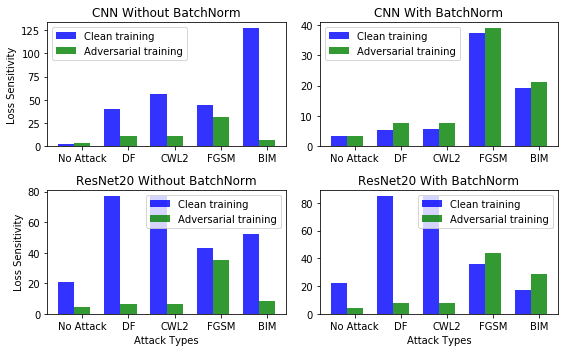

In [88]:
# adv_ls_bn = (adv_ls_clean_bn, adv_ls_df_bn, adv_ls_cl2_bn, adv_ls_fgsm_bn, adv_ls_ifgsm_bn)
# adv_ls = (adv_ls_clean, adv_ls_df, adv_ls_cl2, adv_ls_fgsm, adv_ls_ifgsm)

# rn_adv_ls_bn = (rn_adv_ls_clean_bn, rn_adv_ls_df_bn, rn_adv_ls_cl2_bn, rn_adv_ls_fgsm_bn, rn_adv_ls_ifgsm_bn)
# rn_adv_ls = (rn_adv_ls_clean, rn_adv_ls_df, rn_adv_ls_cl2, rn_adv_ls_fgsm, rn_adv_ls_ifgsm)
# print(adv_ls_bn, adv_ls, rn_adv_ls_bn, rn_adv_ls)

adv_ls_bn = (3.3696384, 7.6457734, 7.6472025, 38.93821, 21.154078) 
adv_ls = (3.3696384, 10.572385, 11.125161, 31.72601, 6.6053834) #81.72601
rn_adv_ls_bn = (4.500889, 7.7116036, 7.758671, 44.110477, 28.451584) 
rn_adv_ls = (4.500889, 6.381096, 6.314416, 35.282787, 8.315595)

ls_bn = (3.5029335, 5.4070783, 5.5447173, 37.311924, 19.31095)
ls = (2.6910212, 40.358677, 55.820187, 44.10589, 127.02045)

resnet_ls_bn = (22.046528, 85.109344, 85.108864, 35.790092, 17.346003) 
resnet_ls = (20.798801, 77.014435, 77.20241, 43.147842, 52.223244)

# data to plot
n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
plt.figure(figsize=(8,5))
# plt.suptitle("Loss Sensitivity for Cifar10 models with and without Adversarial training")

ax1 = plt.subplot(2, 2, 1)
rects1 = plt.bar(index, ls, bar_width, alpha=opacity, color='b', label='Clean training')
rects2 = plt.bar(index + bar_width, adv_ls, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.ylabel('Loss Sensitivity')
ax1.set_title('CNN Without BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax2 = plt.subplot(2, 2, 2)
rects5 = plt.bar(index, ls_bn, bar_width, alpha=opacity, color='b', label='Clean training')
rects6 = plt.bar(index + bar_width, adv_ls_bn, bar_width, alpha=opacity, color='g', label='Adversarial training')
ax2.set_title('CNN With BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()


ax3 = plt.subplot(2, 2, 3)
rects3 = plt.bar(index, resnet_ls, bar_width, alpha=opacity, color='b', label='Clean training')
rects4 = plt.bar(index + bar_width, rn_adv_ls, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.xlabel('Attack Types')
plt.ylabel('Loss Sensitivity')
ax3.set_title('ResNet20 Without BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax4 = plt.subplot(2, 2, 4)
rects7 = plt.bar(index, resnet_ls_bn, bar_width, alpha=opacity, color='b', label='Clean training')
rects8 = plt.bar(index + bar_width, rn_adv_ls_bn, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.xlabel('Attack Types')
ax4.set_title('ResNet20 With BatchNorm')
plt.xticks(index + bar_width, ('No Attack', 'DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

# plt.constrained_layout()
plt.tight_layout()
plt.savefig('cifar10-loss-sensitivity.png')

In [91]:
# (x_train, y_train, x_test, y_test)
# (x_train_bim_adv, x_test_bim_adv) 
# (x_train_fgsm_adv, x_test_fgsm_adv)
# (x_train_deepfool_adv, x_test_deepfool_adv) 
# (x_train_cl2_adv, x_test_cl2_adv) 

x_train[:3000].shape

(3000, 32, 32, 3)

In [93]:
import numpy.linalg as la
N = 3000
bim_perturbation = np.mean(la.norm((x_train-x_train_bim_adv).reshape(x_train.shape[0], -1), 2, axis=1))
fgsm_perturbation = np.mean(la.norm((x_train[:N]-x_train_fgsm_adv).reshape(N, -1), 2, axis=1))
cl2_perturbation = np.mean(la.norm((x_train[:N]-x_train_cl2_adv).reshape(N, -1), 2, axis=1))
df_perturbation = np.mean(la.norm((x_train[:N]-x_train_deepfool_adv).reshape(N, -1), 2, axis=1))

In [94]:
print(bim_perturbation, fgsm_perturbation, cl2_perturbation, df_perturbation)
# [21.44681754576523 5.537018287315439 0.1898634259341559 0.1716863410600156]


21.44681754576523 5.537018287315439 0.1898634259341559 0.1716863410600156


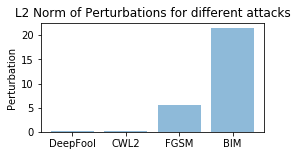

In [111]:
avg_perturbations = (0.1716863410600156, 0.1898634259341559, 5.537018287315439, 21.44681754576523)

plt.figure(figsize=(4,2))
y_pos = np.arange(len(avg_perturbations))
plt.bar(y_pos, avg_perturbations, align='center', alpha=0.5)
plt.xticks(y_pos, ['DeepFool', 'CWL2', 'FGSM', 'BIM'])
plt.title('L2 Norm of Perturbations for different attacks')
# plt.xlabel('Attack Types')
plt.ylabel('Perturbation')
plt.show()
fig.savefig('cifar10-avg-perturbation.png')



In [9]:
import numpy.linalg as la
def deepfool_robustness_metric(clf, x, y, x_adv):
    y_adv = clf.predict(x_adv)
    idxs = (np.argmax(y_adv, axis=1) != np.argmax(y, axis=1))
    if np.sum(idxs) == 0.0:
        return 0
    norm_type = 2
    perts_norm = la.norm((x_adv - x).reshape(x.shape[0], -1), ord=norm_type, axis=1)
    perts_norm = perts_norm[idxs]
    return np.mean(perts_norm / la.norm(x[idxs].reshape(np.sum(idxs), -1), ord=norm_type, axis=1))



In [11]:
def robustness_measure(clf, x, y, x_adv_df, x_adv_cl2, x_adv_fgsm, x_adv_bim):
    df = deepfool_robustness_metric(clf, x, y, x_adv_df)
    cl2 = deepfool_robustness_metric(clf, x, y, x_adv_cl2)
    fgsm = deepfool_robustness_metric(clf, x, y, x_adv_fgsm)
    bim = deepfool_robustness_metric(clf, x, y, x_adv_bim[:3000])
    return (df, cl2, fgsm, bim)


In [123]:
cnn_adv_robustness, cnn_bn_adv_robustness, resnet_adv_robustness, resnet_bn_adv_robustness
# ((0.004800391215291648,
#   0.0080141299196437,
#   0.2025881068827215,
#   0.7826341959283831),
#  (0.005009587935111827,
#   0.00573169152166241,
#   0.20336724387211264,
#   0.7813432613707565),
#  (0.0042878663595054,
#   0.005106235935120835,
#   0.20744157832496612,
#   0.7865361979837541),
#  (0.0037161374017067365,
#   0.004179452234617752,
#   0.20613162784251748,
#   0.7920903346064864))

((0.004800391215291648,
  0.0080141299196437,
  0.2025881068827215,
  0.7826341959283831),
 (0.005009587935111827,
  0.00573169152166241,
  0.20336724387211264,
  0.7813432613707565),
 (0.0042878663595054,
  0.005106235935120835,
  0.20744157832496612,
  0.7865361979837541),
 (0.0037161374017067365,
  0.004179452234617752,
  0.20613162784251748,
  0.7920903346064864))

In [ ]:
cnn_adv_robustness = robustness_measure(cnn_clf_adv_final, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
cnn_bn_adv_robustness = robustness_measure(cnn_bn_clf_adv_final, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
resnet_adv_robustness = robustness_measure(resnet_clf_adv_final, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
resnet_bn_adv_robustness = robustness_measure(resnet_bn_clf_adv_final, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)

In [7]:
c1, model1 = load_clf('/home/surthi/models/cifar10/', 'vanilla_clf.h5', 'vanilla_clf_model.h5')
c1_bn, model1_bn = load_clf('/home/surthi/models/cifar10/', 'vanilla_clf_with_bn.h5', 'vanilla_clf_with_bn_model.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
N = 3000
cnn_robustness = robustness_measure(c1, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
cnn_bn_robustness = robustness_measure(c1_bn, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
resnet_robustness = robustness_measure(resnet, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
resnet_bn_robustness = robustness_measure(resnet_bn, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)

In [9]:
cnn_robustness, cnn_bn_robustness
# ((0.006276674117868981,
#   0.006836447395926339,
#   0.20293084023110255,
#   0.7876819426566969),
#  (0.003833067200772092,
#   0.006224990189155943,
#   0.20115901631374167,
#   0.7880658195856696))

((0.006276674117868981,
  0.006836447395926339,
  0.20293084023110255,
  0.7876819426566969),
 (0.003833067200772092,
  0.006224990189155943,
  0.20115901631374167,
  0.7880658195856696))

In [7]:
resnet, resnet_model = load_clf('/home/surthi/models/cifar10/', 'resnet_clf.h5', 'resnet_clf_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [13]:
N=3000
resnet_robustness = robustness_measure(resnet, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
print(resnet_robustness)
# (0.004745267307272102, 0.005407675361007732, 0.20239407424129968, 0.787927356842619)


(0.004745267307272102, 0.005407675361007732, 0.20239407424129968, 0.787927356842619)


In [14]:
resnet_bn, resnet_model_bn = load_clf('/home/surthi/models/cifar10/', 'resnet_clf_bn.h5', 'resnet_clf_model_bn.h5')

In [16]:
N = 3000
resnet_bn_robustness = robustness_measure(resnet_bn, x_train[:N], y_train[:N], x_train_deepfool_adv, x_train_cl2_adv, x_train_fgsm_adv, x_train_bim_adv)
print(resnet_bn_robustness)
# (0.005222071329926856, 0.005977269449019326, 0.2023581322371249, 0.7834574705904217)

(0.005222071329926856, 0.005977269449019326, 0.2023581322371249, 0.7834574705904217)


In [19]:
(cnn_adv_robustness, cnn_bn_adv_robustness, 
 resnet_adv_robustness, resnet_bn_adv_robustness, 
 cnn_robustness, cnn_bn_robustness, 
 resnet_robustness, resnet_bn_robustness) = (
(0.004800391215291648,0.0080141299196437,  0.2025881068827215,  0.7826341959283831),
 (0.005009587935111827,  0.00573169152166241,  0.20336724387211264,  0.7813432613707565),
 (0.0042878663595054,  0.005106235935120835,  0.20744157832496612,  0.7865361979837541),
 (0.0037161374017067365,  0.004179452234617752,  0.20613162784251748,  0.7920903346064864),
(0.006276674117868981,  0.006836447395926339,  0.20293084023110255,  0.7876819426566969),
(0.003833067200772092,  0.006224990189155943,  0.20115901631374167,  0.7880658195856696),
(0.004745267307272102, 0.005407675361007732, 0.20239407424129968, 0.787927356842619),
(0.005222071329926856, 0.005977269449019326, 0.2023581322371249, 0.7834574705904217))

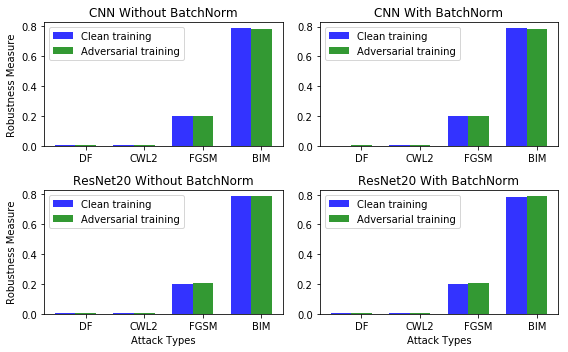

In [21]:
import matplotlib.pyplot as plt
# data to plot
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
plt.figure(figsize=(8,5))
# plt.suptitle("Loss Sensitivity for Cifar10 models with and without Adversarial training")

ax1 = plt.subplot(2, 2, 1)
rects1 = plt.bar(index, cnn_robustness, bar_width, alpha=opacity, color='b', label='Clean training')
rects2 = plt.bar(index + bar_width, cnn_adv_robustness, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.ylabel('Robustness Measure')
ax1.set_title('CNN Without BatchNorm')
plt.xticks(index + bar_width, ('DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax2 = plt.subplot(2, 2, 2)
rects5 = plt.bar(index, cnn_bn_robustness, bar_width, alpha=opacity, color='b', label='Clean training')
rects6 = plt.bar(index + bar_width, cnn_bn_adv_robustness, bar_width, alpha=opacity, color='g', label='Adversarial training')
ax2.set_title('CNN With BatchNorm')
plt.xticks(index + bar_width, ('DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()


ax3 = plt.subplot(2, 2, 3)
rects3 = plt.bar(index, resnet_robustness, bar_width, alpha=opacity, color='b', label='Clean training')
rects4 = plt.bar(index + bar_width, resnet_adv_robustness, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.xlabel('Attack Types')
plt.ylabel('Robustness Measure')
ax3.set_title('ResNet20 Without BatchNorm')
plt.xticks(index + bar_width, ('DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

ax4 = plt.subplot(2, 2, 4)
rects7 = plt.bar(index, resnet_bn_robustness, bar_width, alpha=opacity, color='b', label='Clean training')
rects8 = plt.bar(index + bar_width, resnet_bn_adv_robustness, bar_width, alpha=opacity, color='g', label='Adversarial training')
plt.xlabel('Attack Types')
ax4.set_title('ResNet20 With BatchNorm')
plt.xticks(index + bar_width, ('DF', 'CWL2', 'FGSM', 'BIM'))
plt.legend()

# plt.constrained_layout()
plt.tight_layout()